In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
import datetime
import time

Found 300 files belonging to 3 classes.
Using 240 files for training.
Found 300 files belonging to 3 classes.
Using 60 files for validation.


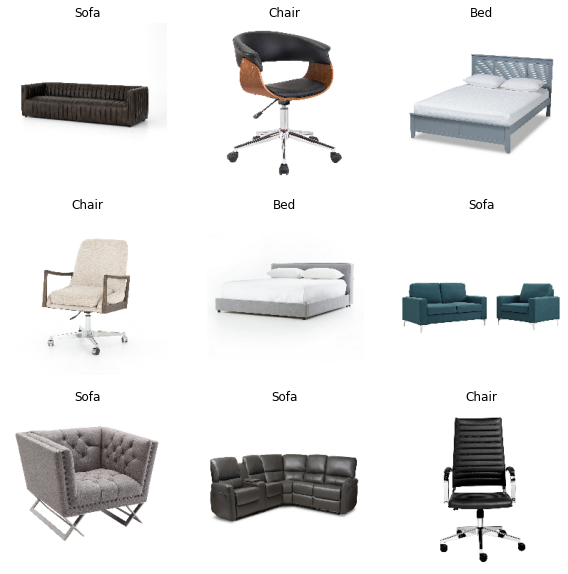

In [20]:
# Dataset Preparation
pixels = 224
IMG_SIZE = (pixels, pixels)
train_dir = "path_to_datset"

train_dataset = image_dataset_from_directory(train_dir, shuffle=True,seed=32,image_size=IMG_SIZE,validation_split=0.2,subset="training")
validation_dataset = image_dataset_from_directory(train_dir, shuffle=True,seed=32,image_size=IMG_SIZE,validation_split=0.2,subset="validation")

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
# Dataset Tuning
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (norm_layer(x), y))
validation_dataset = validation_dataset.map(lambda x,y: (norm_layer(x),y))
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=autotune)

In [27]:
# Transfer Learning - Base model and classification head setup
feature_extractor_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' 

feature_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224,224,3),
    trainable=True)

num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(num_classes)])
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(train_dataset,validation_data=validation_dataset,epochs=10)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 29s 3s/step - loss: 0.4797 - accuracy: 0.8292 - val_loss: 0.5914 - val_accuracy: 0.8500
Epoch 2/10
8/8 [==============================] - 23s 3s/step - loss: 0.1221 - accuracy: 0.9792 - val_loss: 1.5351 - val_accuracy: 0.7500
Epoch 3/10
8/8 [==============================] - 23s 3s/step - loss: 0.0906 - accuracy: 1.0000 - val_loss: 1.9632 - val_accuracy: 0.8167
Epoch 4/10
8/8 [==============================] - 23s 3s/step - loss: 0.0879 - accuracy

In [31]:
# Testing and saving model
img = tf.keras.preprocessing.image.load_img('path_to_test_image', target_size=(pixels, pixels))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.
images = np.vstack([x])
classes = model.predict(images)
print(classes)
model.save('prediction_model')

[[ -5.468675  31.91361  -30.17528 ]]
INFO:tensorflow:Assets written to: prediction_model/assets


INFO:tensorflow:Assets written to: prediction_model/assets
